# Regression Imputation


Definition:
Regression imputation fits a statistical model on a variable with missing values. Predictions of this regression model are used to substitute the missing values in this variable.

Regression imputation consists of two subsequent steps:

>1. A linear regression model is estimated on the basis of observed values in the target variable Y and some explanatory variables X.

>2. The model is used to predict values for the missing cases in Y. Missing values of Y are then replaced on the basis of these predictions.

Relationships of X and Y (i.e. correlations, regression coefficients etc.) are preserved, since imputed values are based on regression models. This is a big advantage over simpler imputation methods such as mean imputation or zero substitution.

Regression imputation is classified into **two different versions**: deterministic and stochastic regression imputation.

**Deterministic regression imputation** replaces missing values with the exact prediction of the regression model. Random variation (i.e. an error term) around the regression slope is not considered. Imputed values are therefore often too precise and lead to an overestimation of the correlation between X and Y.

**Stochastic regression** imputation was developed in order to solve this issue of deterministic regression imputation. Stochastic regression imputation adds a random error term to the predicted value and is therefore able to reproduce the correlation of X and Y more appropriately.

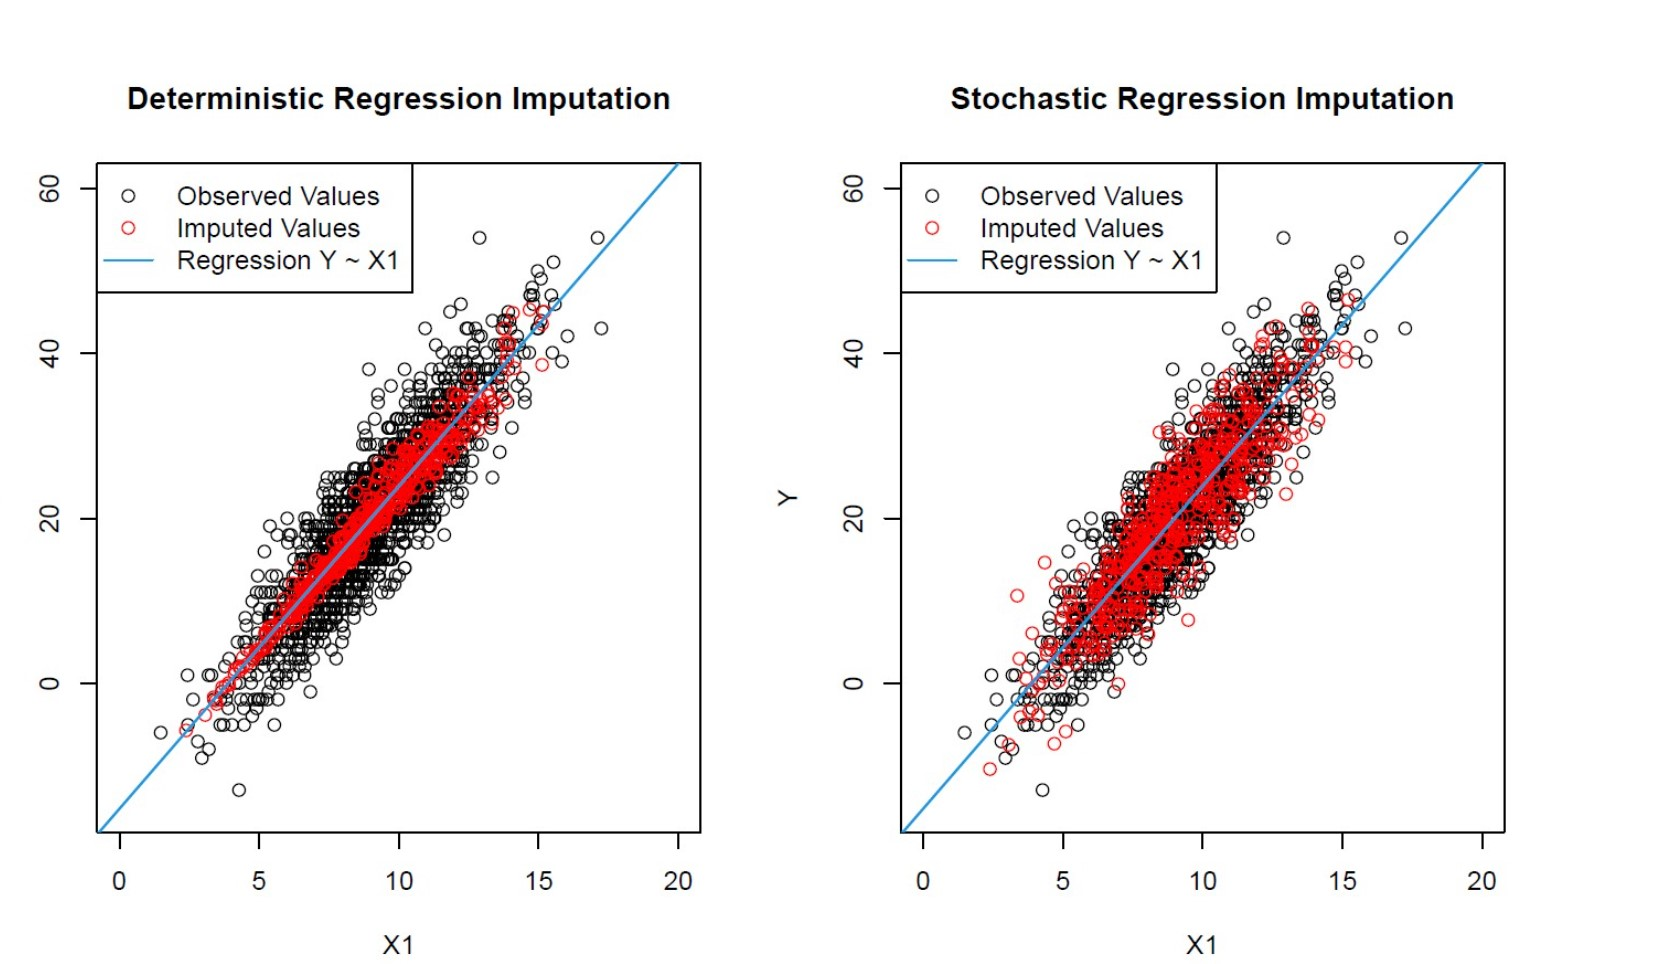

## Drawback

**Drawback 1**: Stochastic regression imputation may lead to **implausible values**. Variables are often restricted to a certain range of values (e.g. income should always be positive). Regression imputation is not able to impute according to such restrictions.

**Drawback 2**: Stochastic regression imputation leads to poor results when data is **heteroscedastic**(refers to a condition in which the variance of the residual term, or error term, in a regression model varies widely). The imputation method assumes that the random error has on average the same size for all parts of the distribution, often resulting in too small or too large random error terms for the imputed values.

## Regression imputation with python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

In [3]:
df = pd.read_csv("diabetes.csv")
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None of the variables seem to have any missing value based on our above observation.  

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


df.describe() which gives the Five Number Summary would show that some variables have 0.0 as their minimum value which would be meaningless in their case. Plasma glucose concentration, Diastolic blood pressure, Triceps skinfold thickness, 2-Hour serum insulin and Body mass index cannot be zero.

Imagine BMI to be zero. That would be a disaster!

On the contrary, Pregnencies can be zero because either that person is a female who has not had a baby yet.

>Thus, for feasibility of further analysis, we replace all these "missing" data with nan

In [6]:
df.loc[df["Glucose"] == 0.0, "Glucose"] = np.NAN
df.loc[df["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
df.loc[df["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
df.loc[df["Insulin"] == 0.0, "Insulin"] = np.NAN
df.loc[df["BMI"] == 0.0, "BMI"] = np.NAN

df.isnull().sum()[1:6]

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

<AxesSubplot:>

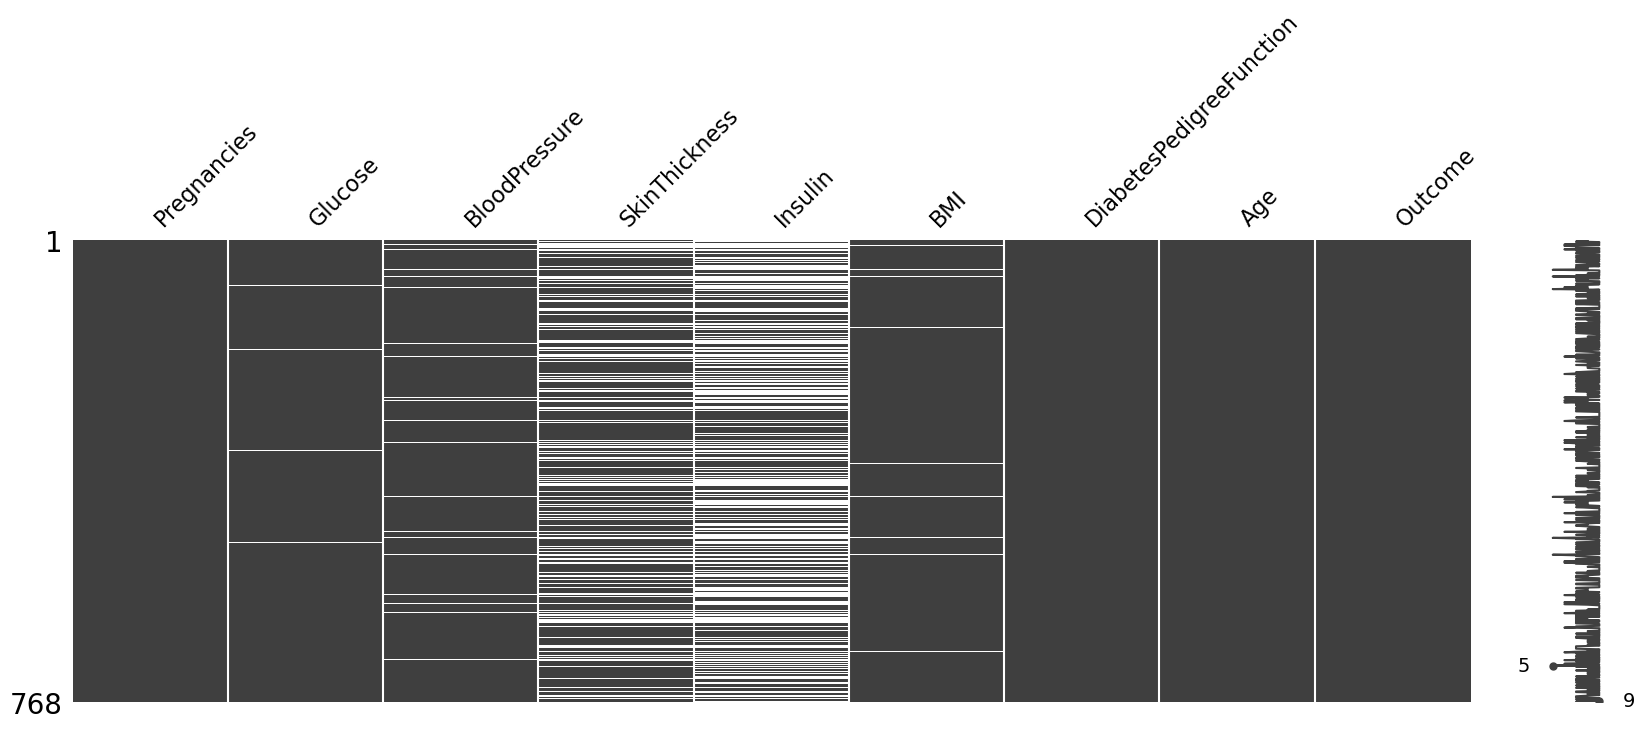

In [7]:
mno.matrix(df, figsize = (20, 6))

## Using Regression to impute missing data

When we have multiple variables with missing values, we can't just directly use Regression Imputation to impute one of them as the predictors contain missing data themselves. But then, how can we impute one variable without imputing another?

We can avoid this Catch-22 situation by initially imputing all the variables with missing values using some trivial methods like **Simple Random Imputation** (we impute the missing data with random observed values of the variable) which is later followed by Regression Imputation of each of the variables iteratively.

In [8]:
missing_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

The function random_imputation replaces the missing values with some random observed values of the variable. The method is repeated for all the variables containing missing values, after which they serve as parameters in the regression model to estimate other variable values.

Simple Random Imputation is one of the crude methods since it ignores all the other available data and thus it's very rarely used. But it serves as a good starting point for regression imputation.

In [13]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [14]:
for feature in missing_columns:
    df[feature + '_imp'] = df[feature]
    df = random_imputation(df, feature)

### Deterministic Regression Imputation

In Deterministic Regression Imputation, we replace the missing data with the values predicted in our regression model and repeat this process for each variable.

In [16]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = df[feature + "_imp"]
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

In [19]:
deter_data.isnull().sum()

DetGlucose          0
DetBloodPressure    0
DetSkinThickness    0
DetInsulin          0
DetBMI              0
dtype: int64

<AxesSubplot:>

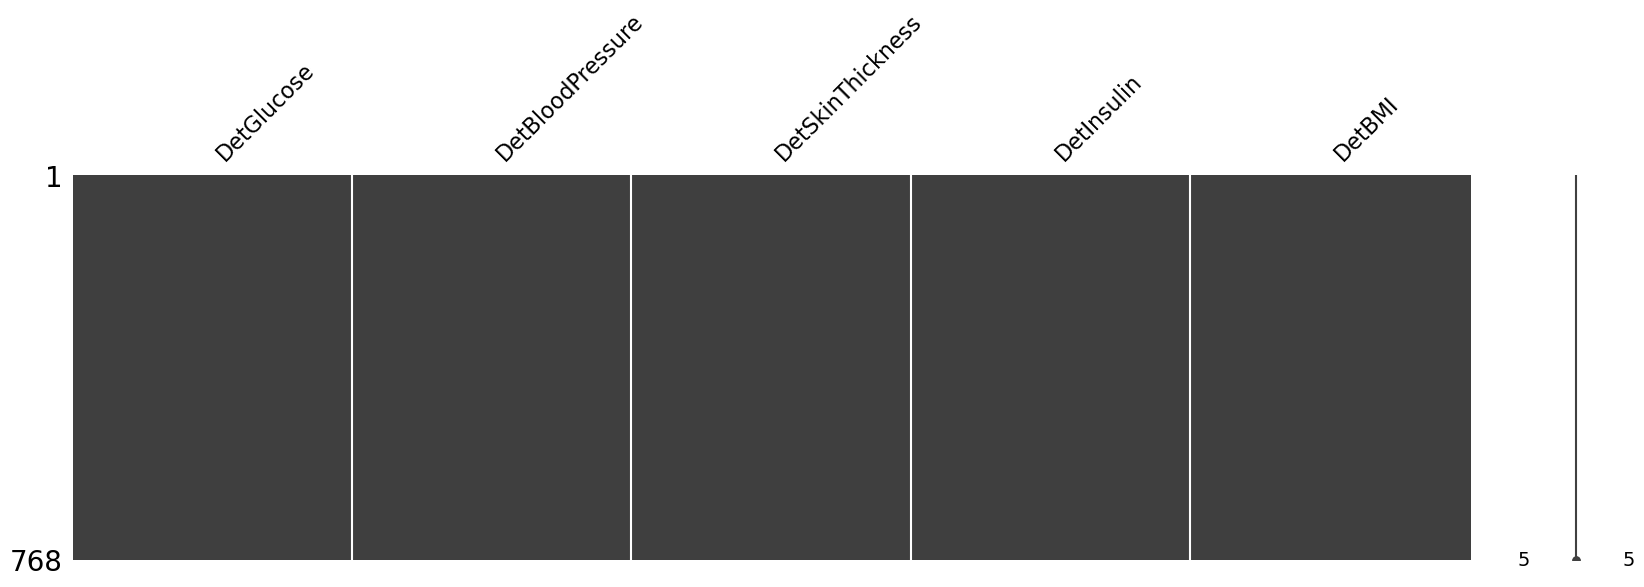

In [11]:
mno.matrix(deter_data, figsize = (20,5))

A major **disadvantage** in this method is that we reduce the inherent variability in the imputed variable. In other words, since we substitute the missing data with regression outputs, the predicted values lie along the regression hyperplane where the variable would have actually contained some **noise/bias**.

We can **visualize** the above fact in a number of ways. First one is plotting histograms for both the incomplete data and the complete data in which we can observe that the plot of the completed data is **taller and narrower** when compared to that of the incomplete data. In other words, the complete data has a **lesser standard deviation (thus lesser variability)** than the incomplete data.

Another method would be plotting a boxplot in which we can observe that the IQ Range is pretty compressed for the complete data when compared to that in the incomplete data.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


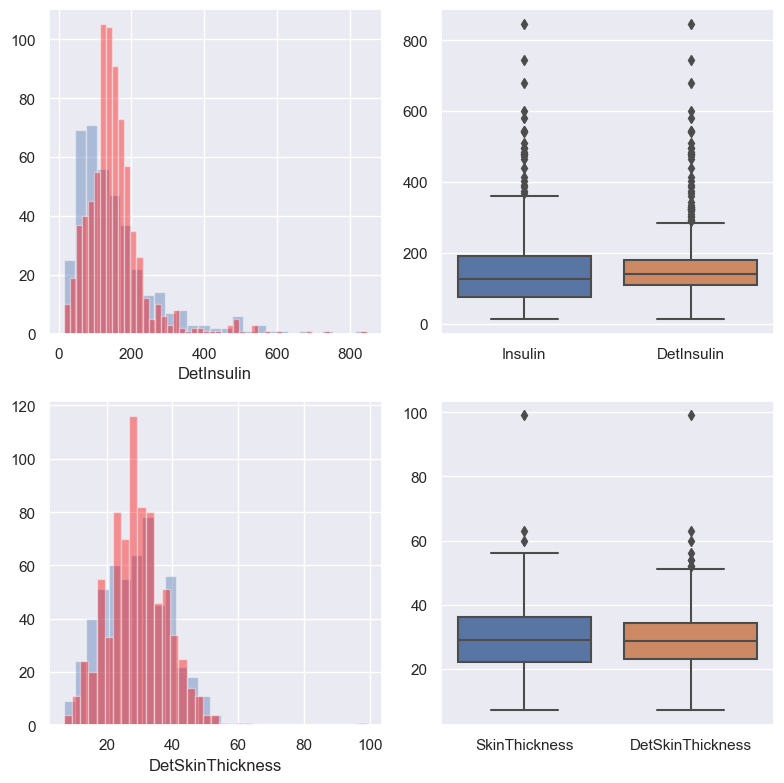

In [12]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')
    
    sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                ax = axes[index, 1])
    
plt.tight_layout()

In [13]:
pd.concat([df[["Insulin", "SkinThickness"]], deter_data[["DetInsulin", "DetSkinThickness"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.0,76.25000,125.000000,190.000000,846.0
SkinThickness,541.0,29.153420,10.476982,7.0,22.00000,29.000000,36.000000,99.0
DetInsulin,768.0,154.335344,88.089336,14.0,109.85566,141.159269,180.000000,846.0
DetSkinThickness,768.0,29.036659,9.193395,7.0,23.00000,28.768400,34.407414,99.0


### Stochastic Regression Imputation

To add uncertainity back to the imputed variable values, we can add some normally distributed noise with a mean of zero and the variance equal to the standard error of regression estimates . This method is called as **Random Imputation** or **Stochastic Regression Imputation**

In [14]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = df[feature + '_imp']
    parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = df[parameters], y = df[feature + '_imp'])
    
    #Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(df[parameters])
    std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()
    
    #observe that I preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = df[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(df[feature].isnull()) & 
                                                                            (random_predict > 0)]

When we introduce this Gaussian noise we may end up imputing some negative values for the missing data due to the spread of the distibution for a particular pair of mean and standard deviation. But, as per our discussion earlier, there might be some variable whose values can never be zero. For example, a negative value for Insulin concentrations would be meaningless.

We can avoid this situation by retaining the values introduced by simple random imputation which is discussed above. This apparently reduces the variability that we introduce, but it's something we have to deal with, especially in case of these variables whose values are restricted to ceratin parts of the real number line.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


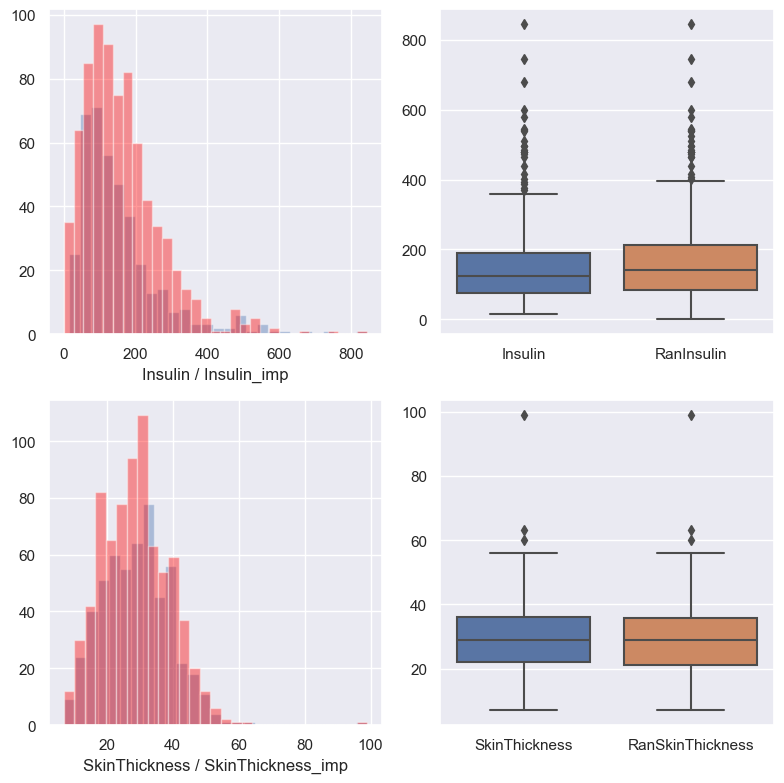

In [15]:
sns.set()
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(8, 8)

for index, variable in enumerate(["Insulin", "SkinThickness"]):
    sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
    axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')
    
    sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])
    
    plt.tight_layout()

We can observe from the plots above that we have introduced some degree of variability into the variables and retained the native distribution as well.

In [16]:
pd.concat([df[["Insulin", "SkinThickness"]], random_data[["RanInsulin", "RanSkinThickness"]]], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Insulin,394.0,155.548223,118.775855,14.000000,76.250000,125.000000,190.000000,846.0
SkinThickness,541.0,29.153420,10.476982,7.000000,22.000000,29.000000,36.000000,99.0
RanInsulin,768.0,161.776500,109.424157,0.187147,84.376835,140.523457,211.376652,846.0
RanSkinThickness,768.0,28.794699,10.269943,7.000000,21.000000,28.891325,35.585408,99.0


An issue of concern about is that, Regression Imputation might not serve as the best method when a variable is missing majority of it's data, as in case of insulin. In these cases we have to use more powerful approaches as Maximum Likelihood Imputation and Multple Imputaton

### References

https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook

https://statisticsglobe.com/regression-imputation-stochastic-vs-deterministic/#theory

https://www.wallstreetmojo.com/heteroskedasticity/#:~:text=The%20most%20basic%20heteroskedastic%20example,items%20and%20bills%E2%80%94less%20variance.

https://www.investopedia.com/terms/h/heteroskedasticity.asp#:~:text=Heteroskedastic%20refers%20to%20a%20condition,a%20regression%20model%20varies%20widely.